Consider the evolution of a simple Hamiltonian into a problem-specific Hamiltonian where the optimal solution is 'encoded' in the ground state of the problem Hamiltonian $\displaystyle H_{\text{P}}$

$$H\left(s\right) = \left(1 - s\right)H_0 + sH_{\text{P}}$$

where

$$H_{\text{P}} = \underbrace{\alpha\left[\overbrace{\sum_{j = 0}^{M - 1}2^jy_j}^{H_{A,~1}} + \overbrace{\left(c + 1 - 2^M\right)y_M}^{H_{A,~2}} - \overbrace{\sum_{i = 1}^nw_ix_i}^{H_{A,~3}}\right]^2}_{H_A} + \underbrace{\left(-\sum_{i = 1}^np_ix_i\right)}_{H_B}$$

for $\displaystyle s = \frac{t}{T}$ where $T$ is the total computation time and $\displaystyle M = \left\lfloor\log_2\left( c - 1\right)\right\rfloor$ s.t. $2^<{\ell + 1}> \leq c < 2^{M + 1}$


In [1]:
from qutip import tensor, sigmaz, qeye, Qobj, mesolve, basis, expect
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#   Tensor product such that i-th element is sigma_z and rest are identity
def tensor_sigmaz(i: int, n: int) -> Qobj:
    ops = [qeye(2) for _ in range(n)]
    ops[i] = sigmaz()
    return tensor(ops)


tensor_sigmaz(0, 1)

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 1.  0.]
 [ 0. -1.]]

In [3]:
#   Parameters to set
profits = np.array([10, 2])
weights = np.array([1, 2])
capacity = 2

#   Derived parameters
num_items = profits.shape[0]
alpha = np.max(profits) + 1
M = int(np.floor(np.log2(capacity)))

total_qubits = num_items + M + 1
num_states = np.power(2, total_qubits)

print(
    f"Total qubits: {num_items} (no. of items) + {M + 1} (ancillary qubits) = {total_qubits}"
)

Total qubits: 2 (no. of items) + 2 (ancillary qubits) = 4


In [4]:
#   Initial Hamiltonian H_0
H_0 = sum(tensor_sigmaz(i, total_qubits) for i in range(total_qubits))

H_0

Quantum object: dims=[[2, 2, 2, 2], [2, 2, 2, 2]], shape=(16, 16), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 4.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -2.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  2.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -2.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. 

In [5]:
H_A1 = sum(
    np.power(2, j) * tensor_sigmaz(j, total_qubits)
    for j in range(num_items, num_items + M)
)  #   starting from the 1st ancillary qubit

H_A1

Quantum object: dims=[[2, 2, 2, 2], [2, 2, 2, 2]], shape=(16, 16), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 4.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  4.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -4.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -4.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  4.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  4.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -4.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -4.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  4.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  4.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -4.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -4.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  4.  0.  0.  0.]
 [ 0.  0.  0. 

In [6]:
H_A2 = (capacity + 1 - np.power(2, M)) * tensor_sigmaz(num_items + M, total_qubits)

H_A2

Quantum object: dims=[[2, 2, 2, 2], [2, 2, 2, 2]], shape=(16, 16), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0. 

In [7]:
H_A3 = -sum(weights[i] * tensor_sigmaz(i, total_qubits) for i in range(num_items))

H_A3

Quantum object: dims=[[2, 2, 2, 2], [2, 2, 2, 2]], shape=(16, 16), type='oper', dtype=CSR, isherm=True
Qobj data =
[[-3.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -3.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -3.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -3.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  3.  0.  0.  0.]
 [ 0.  0.  0. 

In [8]:
#   Problem Hamiltonian H_P
H_A = alpha * (H_A1 + H_A2 + H_A3) ** 2

H_A

Quantum object: dims=[[2, 2, 2, 2], [2, 2, 2, 2]], shape=(16, 16), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 44.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0. 396.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   0. 704.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.   0. 396.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.   0.   0. 176.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.   0.   0.   0.  44.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.   0.   0.   0.   0. 176.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0. 176.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.  44.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.   0.   0.   0.   0

In [9]:
H_B = -sum(profits[i] * tensor_sigmaz(i, total_qubits) for i in range(num_items))

H_B

Quantum object: dims=[[2, 2, 2, 2], [2, 2, 2, 2]], shape=(16, 16), type='oper', dtype=CSR, isherm=True
Qobj data =
[[-12.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0. -12.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0. -12.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   0. -12.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.   0.  -8.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.   0.   0.  -8.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.   0.   0.   0.  -8.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.  -8.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   8.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   8.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.   0.   0.   0.   0

In [10]:
H_P = H_A + H_B

H_P

Quantum object: dims=[[2, 2, 2, 2], [2, 2, 2, 2]], shape=(16, 16), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 32.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0. -12.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0. 384.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   0. 692.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.   0. 388.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.   0.   0. 168.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.   0.   0.   0.  36.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.   0.   0.   0.   0. 168.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0. 184.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.  52.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.   0.   0.   0.   0

In [11]:
#   Obtain the ground eigenstate of H_0
ground_eigenvalue, ground_eigenvector = H_0.groundstate()

psi0 = ground_eigenvector

print(f'Ground eigenvalue = {ground_eigenvalue}\nGround state:')

psi0


# def create_uniform_superposition(n):
#     single_qubit_superposition = (basis(2, 0) + basis(2, 1)).unit()
#     return tensor([single_qubit_superposition] * n)


# psi0 = create_uniform_superposition(total_qubits)

# psi0

Ground eigenvalue = -4.0
Ground state:


Quantum object: dims=[[2, 2, 2, 2], [1, 1, 1, 1]], shape=(16, 1), type='ket', dtype=Dense
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]]

In [12]:
times = np.linspace(0, 1, 10000)


#   Time-dependent Hamiltonian function
def H(s):
    return (1 - s) * H_0 + s * H_P

In [13]:
result = mesolve(H, psi0, times, [], [])

psi_final = result.states[-1]

psi_final

c:\Users\raw_asparagus\AppData\Local\Programs\Python\Python312\Lib\site-packages\qutip\solver\solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


Quantum object: dims=[[2, 2, 2, 2], [1, 1, 1, 1]], shape=(16, 1), type='ket', dtype=Dense
Qobj data =
[[0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.64675071-0.76270146j]]

In [14]:
def generate_basis_states(n):
    """Generates a list of all basis states for 'num_qubits' qubits."""
    return [
        tensor([basis(2, (i >> m) % 2) for m in range(n - 1, -1, -1)])
        for i in range(num_states)
    ]


basis_states = generate_basis_states(total_qubits)

In [15]:
probabilities = []

for psi in result.states:
    probs = [np.abs(basis_state.dag() * psi) ** 2 for basis_state in basis_states]
    probabilities.append(probs)

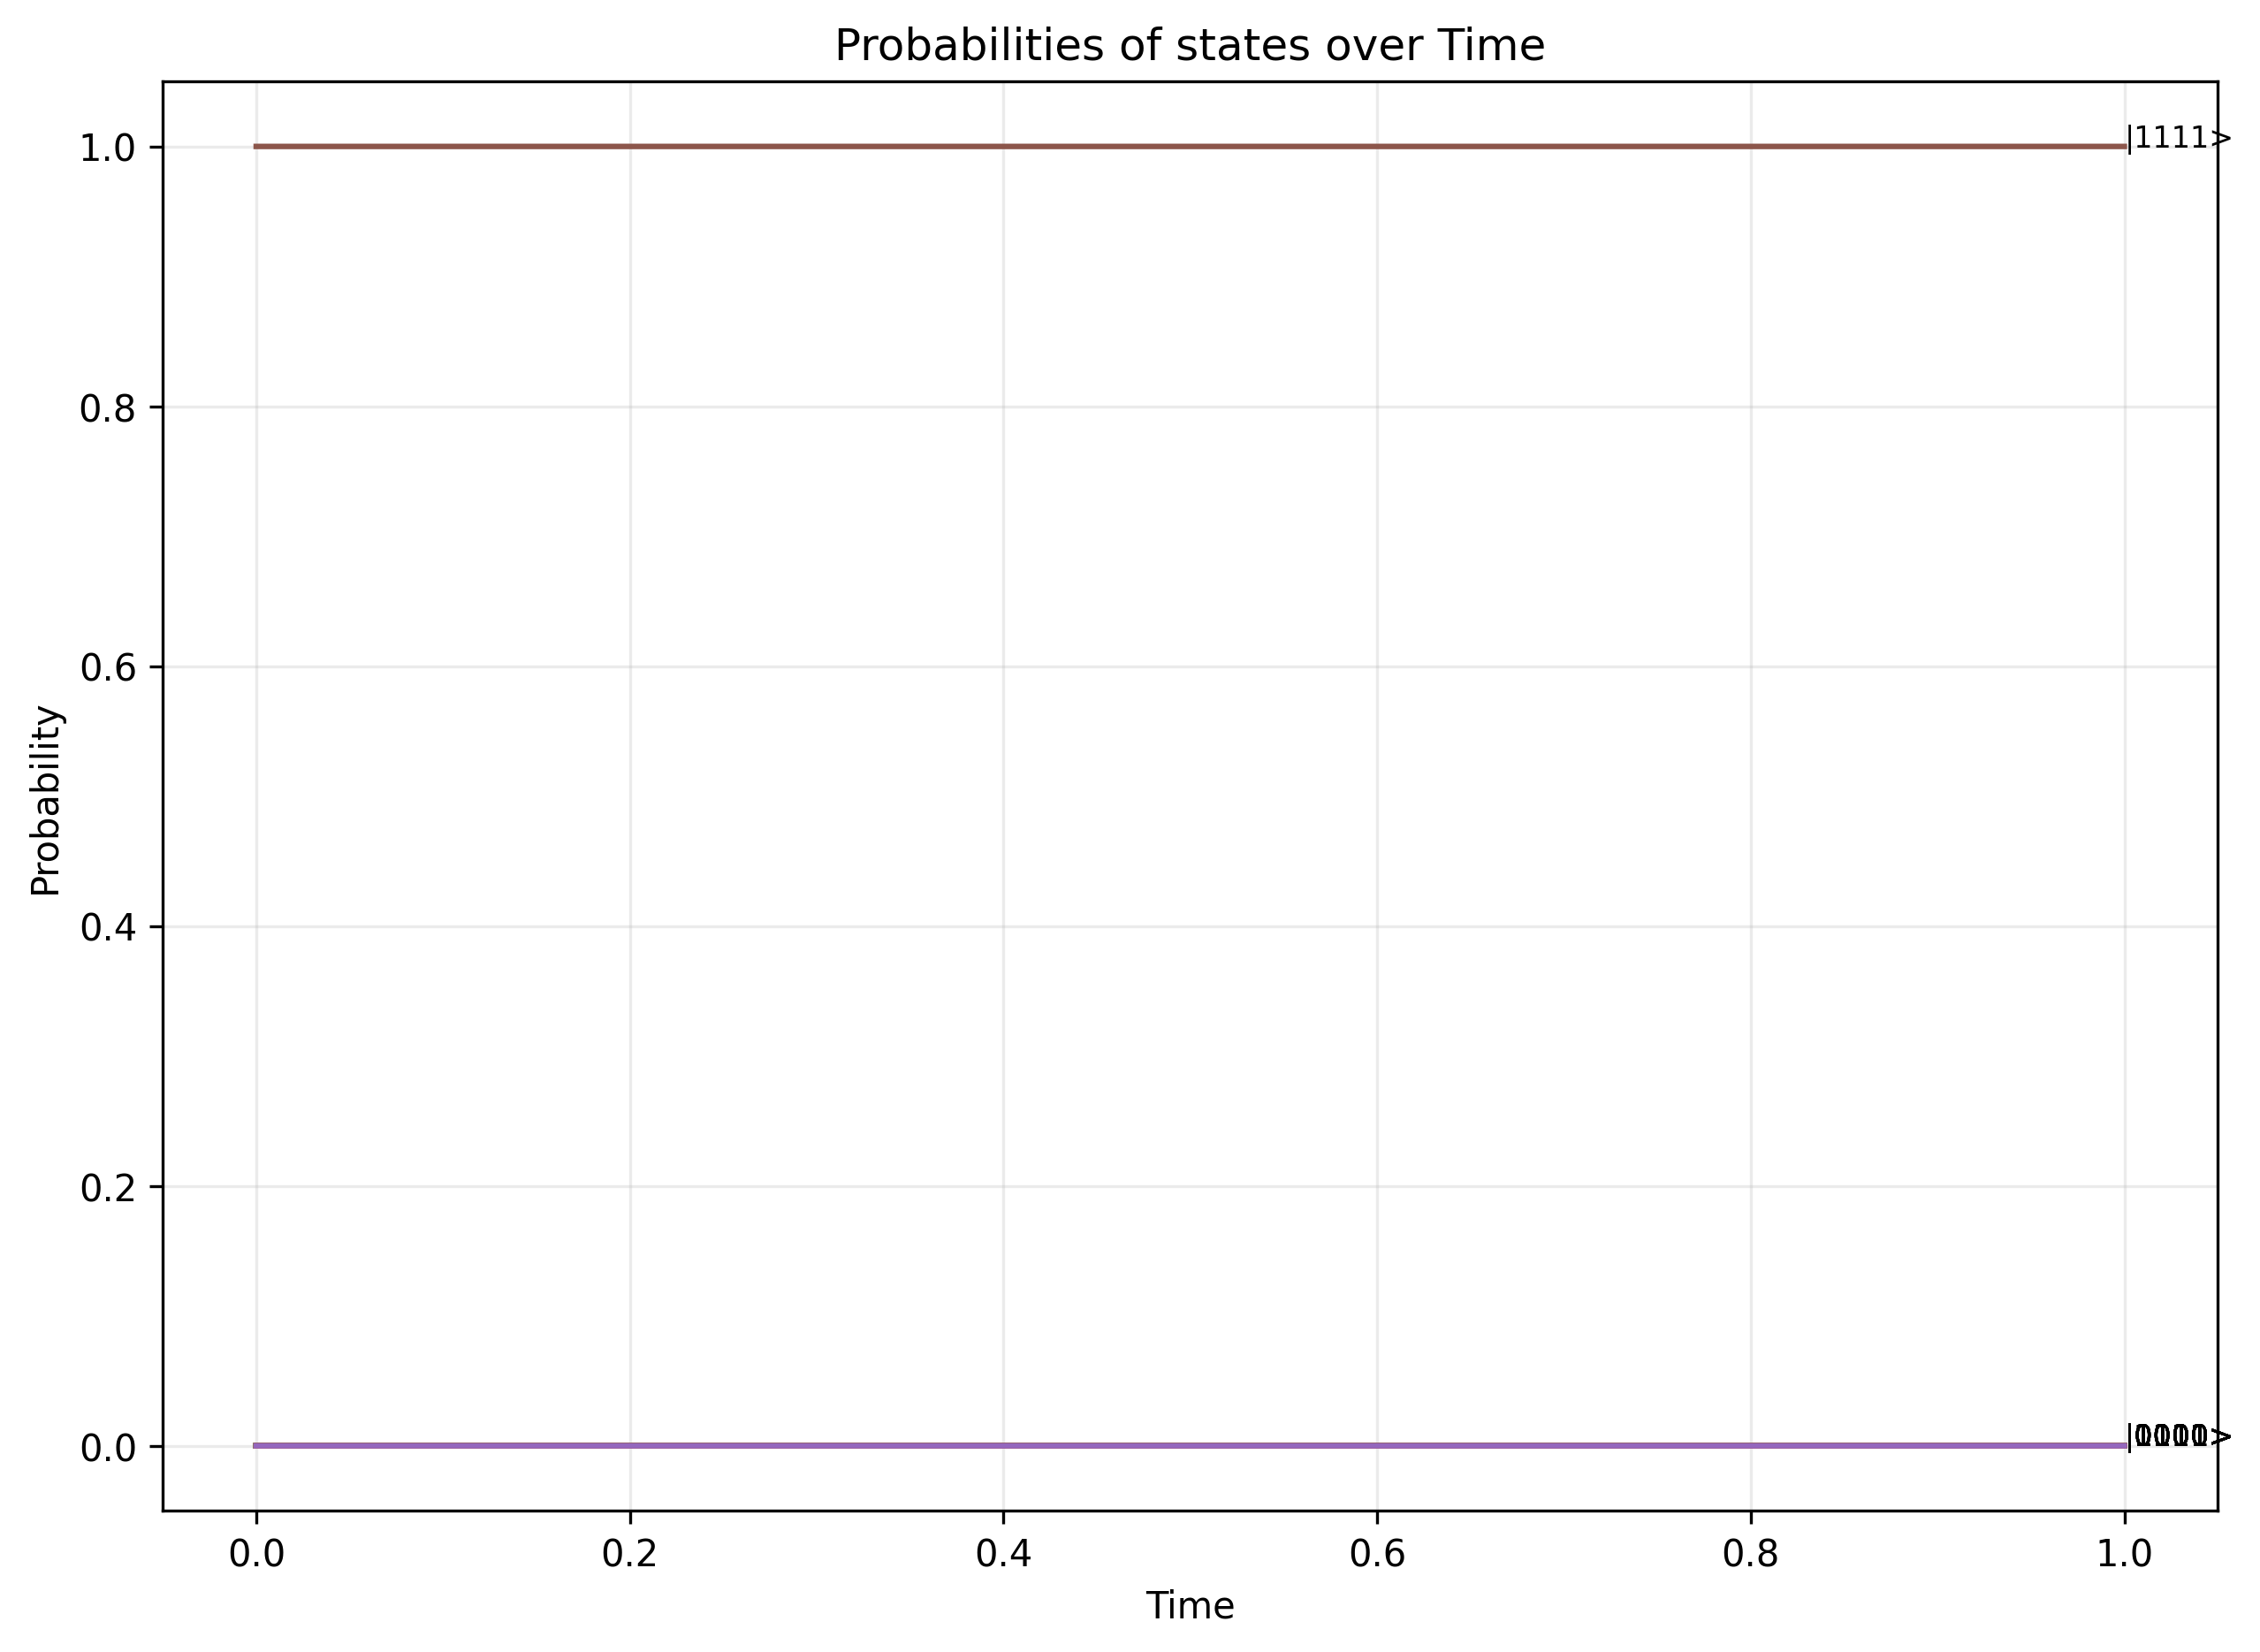

In [16]:
plt.figure(figsize=(10, 7), dpi=300)
for idx in range(num_states):
    plt.plot(
        times,
        [prob[idx] for prob in probabilities],
        label=f'|{format(idx, "0" + str(total_qubits) + "b")}>',
    )
    plt.text(
        times[-1],
        probabilities[-1][idx],
        f'|{format(idx, "0" + str(total_qubits) + "b")}>',
        fontsize=8,
    )

plt.xlabel("Time")
plt.ylabel("Probability")
plt.ylim(-0.05, 1.05)
plt.title("Probabilities of states over Time")
plt.grid(True, alpha=0.25)
plt.show()

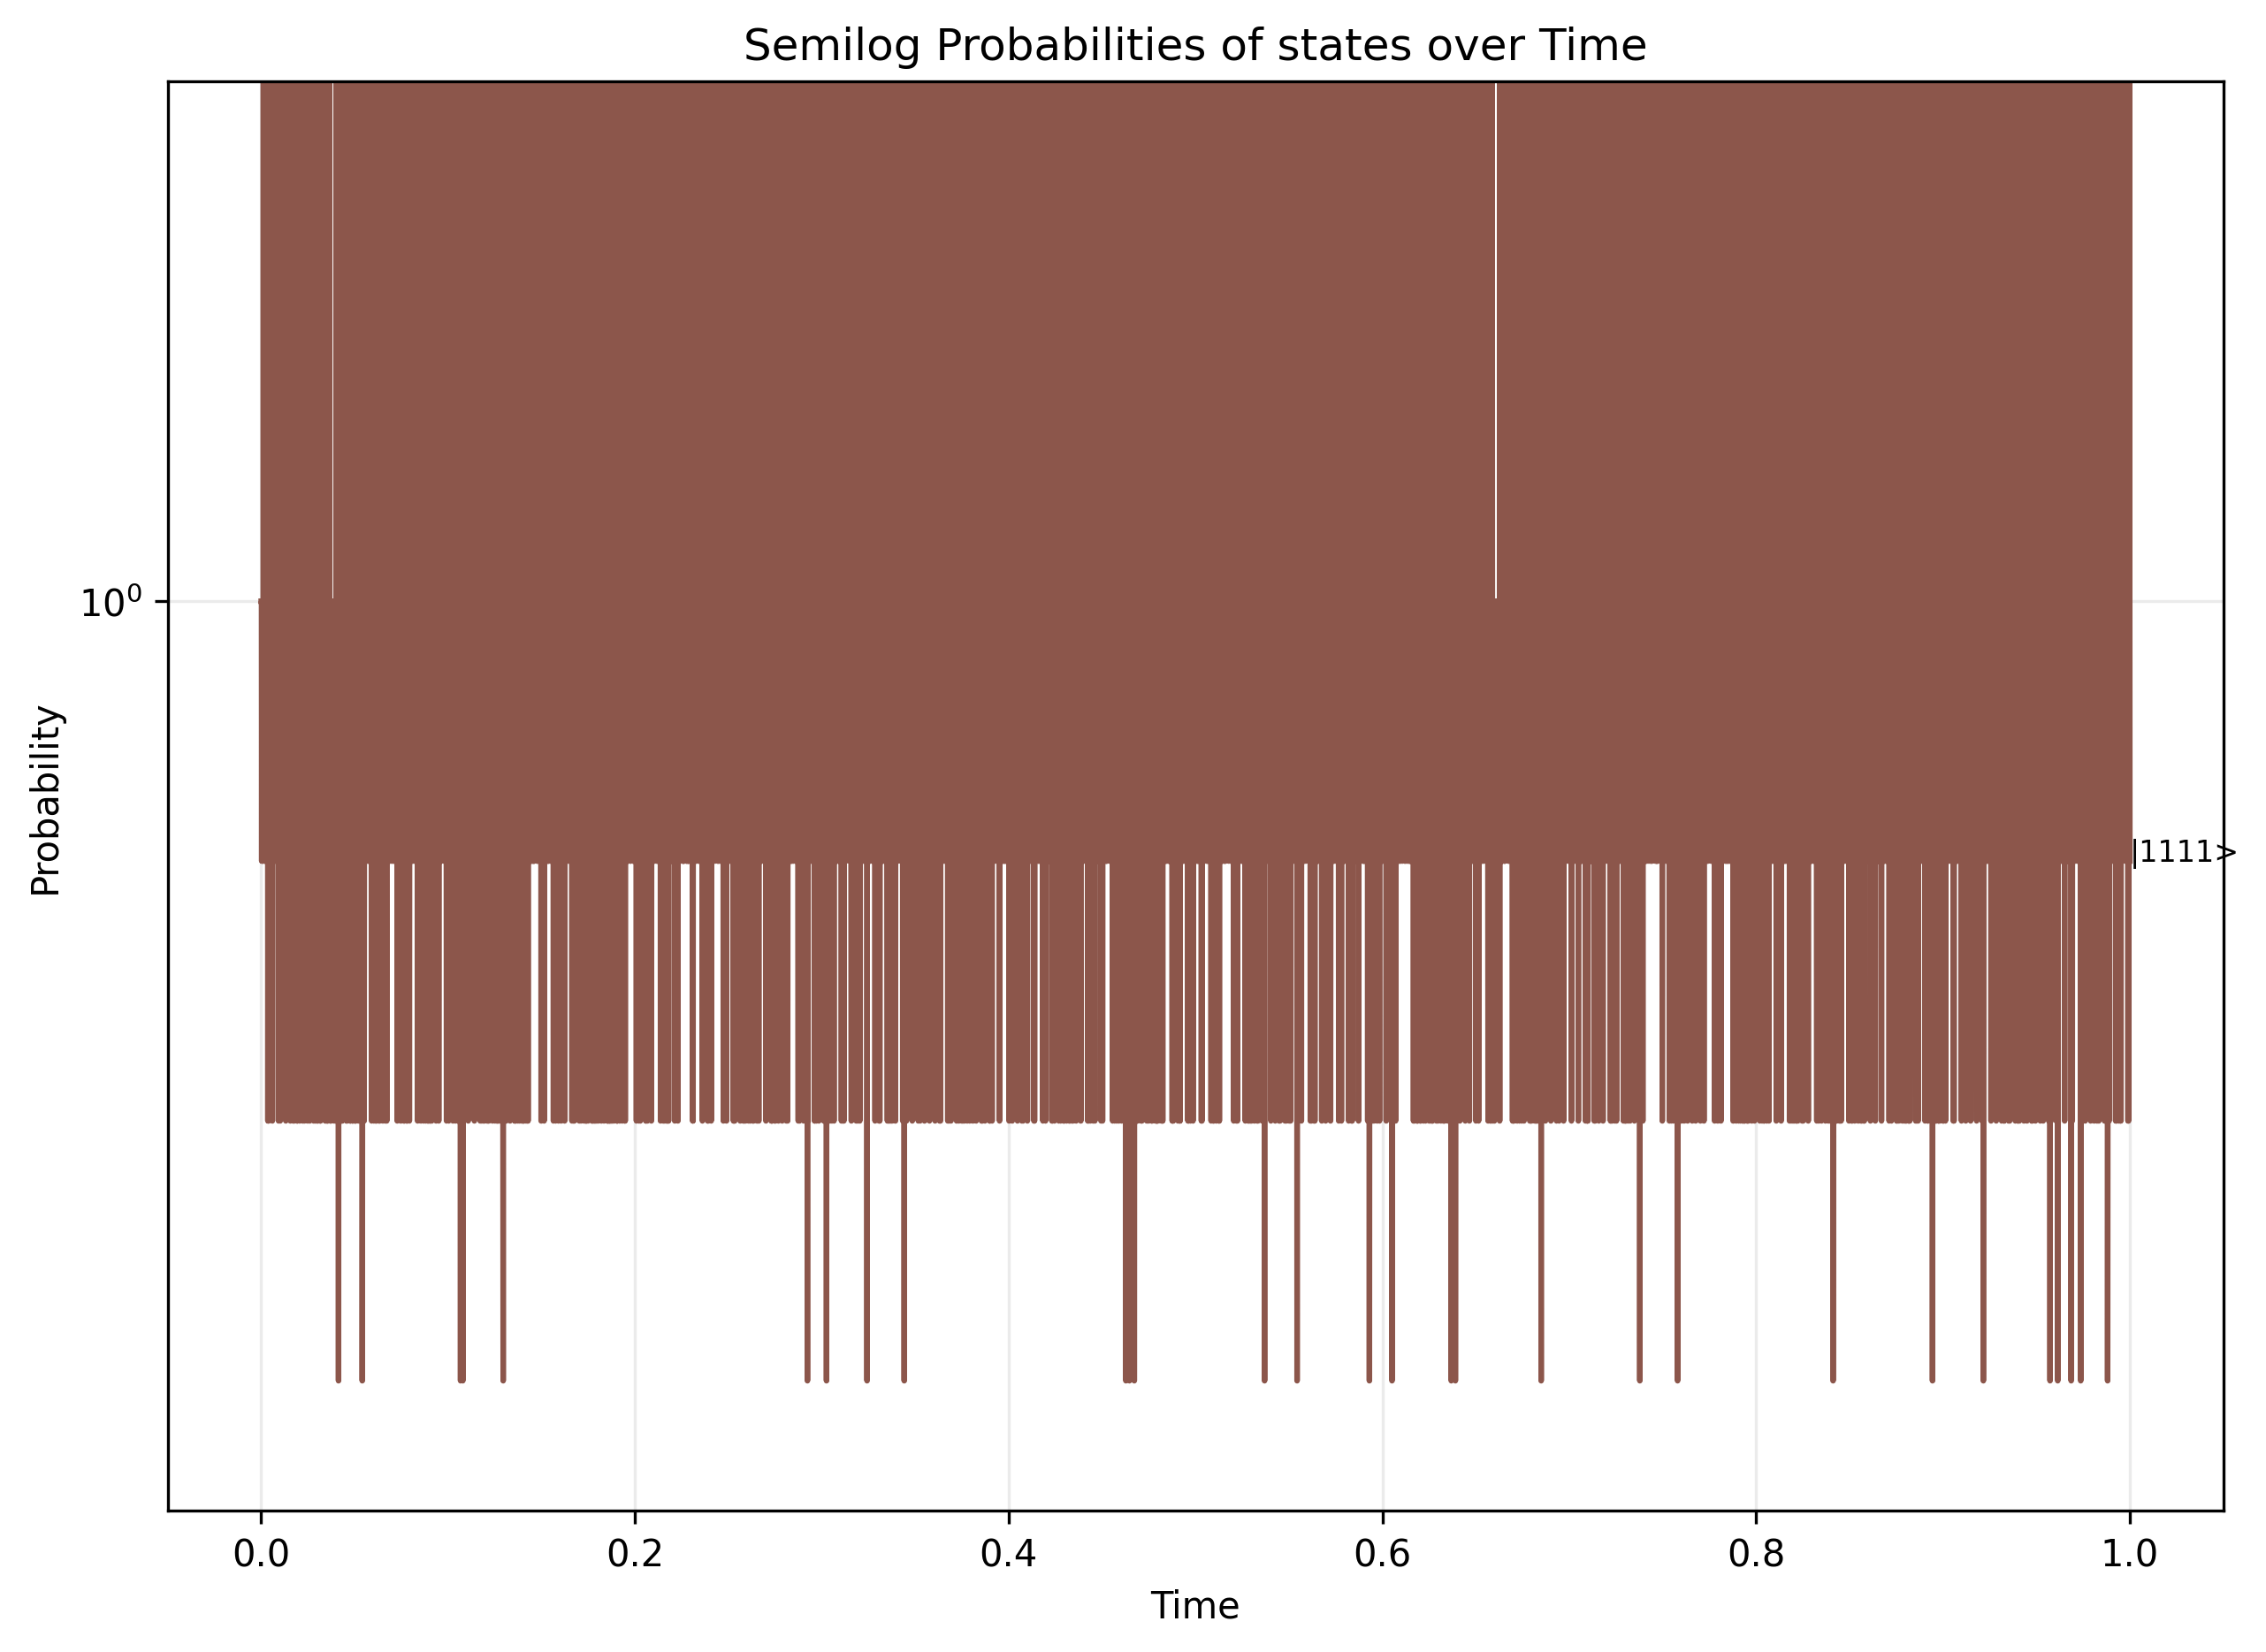

In [17]:
plt.figure(figsize=(10, 7), dpi=300)
for idx in range(num_states):
    plt.semilogy(
        times,
        [prob[idx] for prob in probabilities],
        label=f'|{format(idx, "0" + str(total_qubits) + "b")}>',
    )
    plt.text(
        times[-1],
        probabilities[-1][idx],
        f'|{format(idx, "0" + str(total_qubits) + "b")}>',
        fontsize=8,
    )


plt.xlabel("Time")
plt.ylabel("Probability")
plt.title("Semilog Probabilities of states over Time")
plt.grid(True, alpha=0.25)
plt.show()

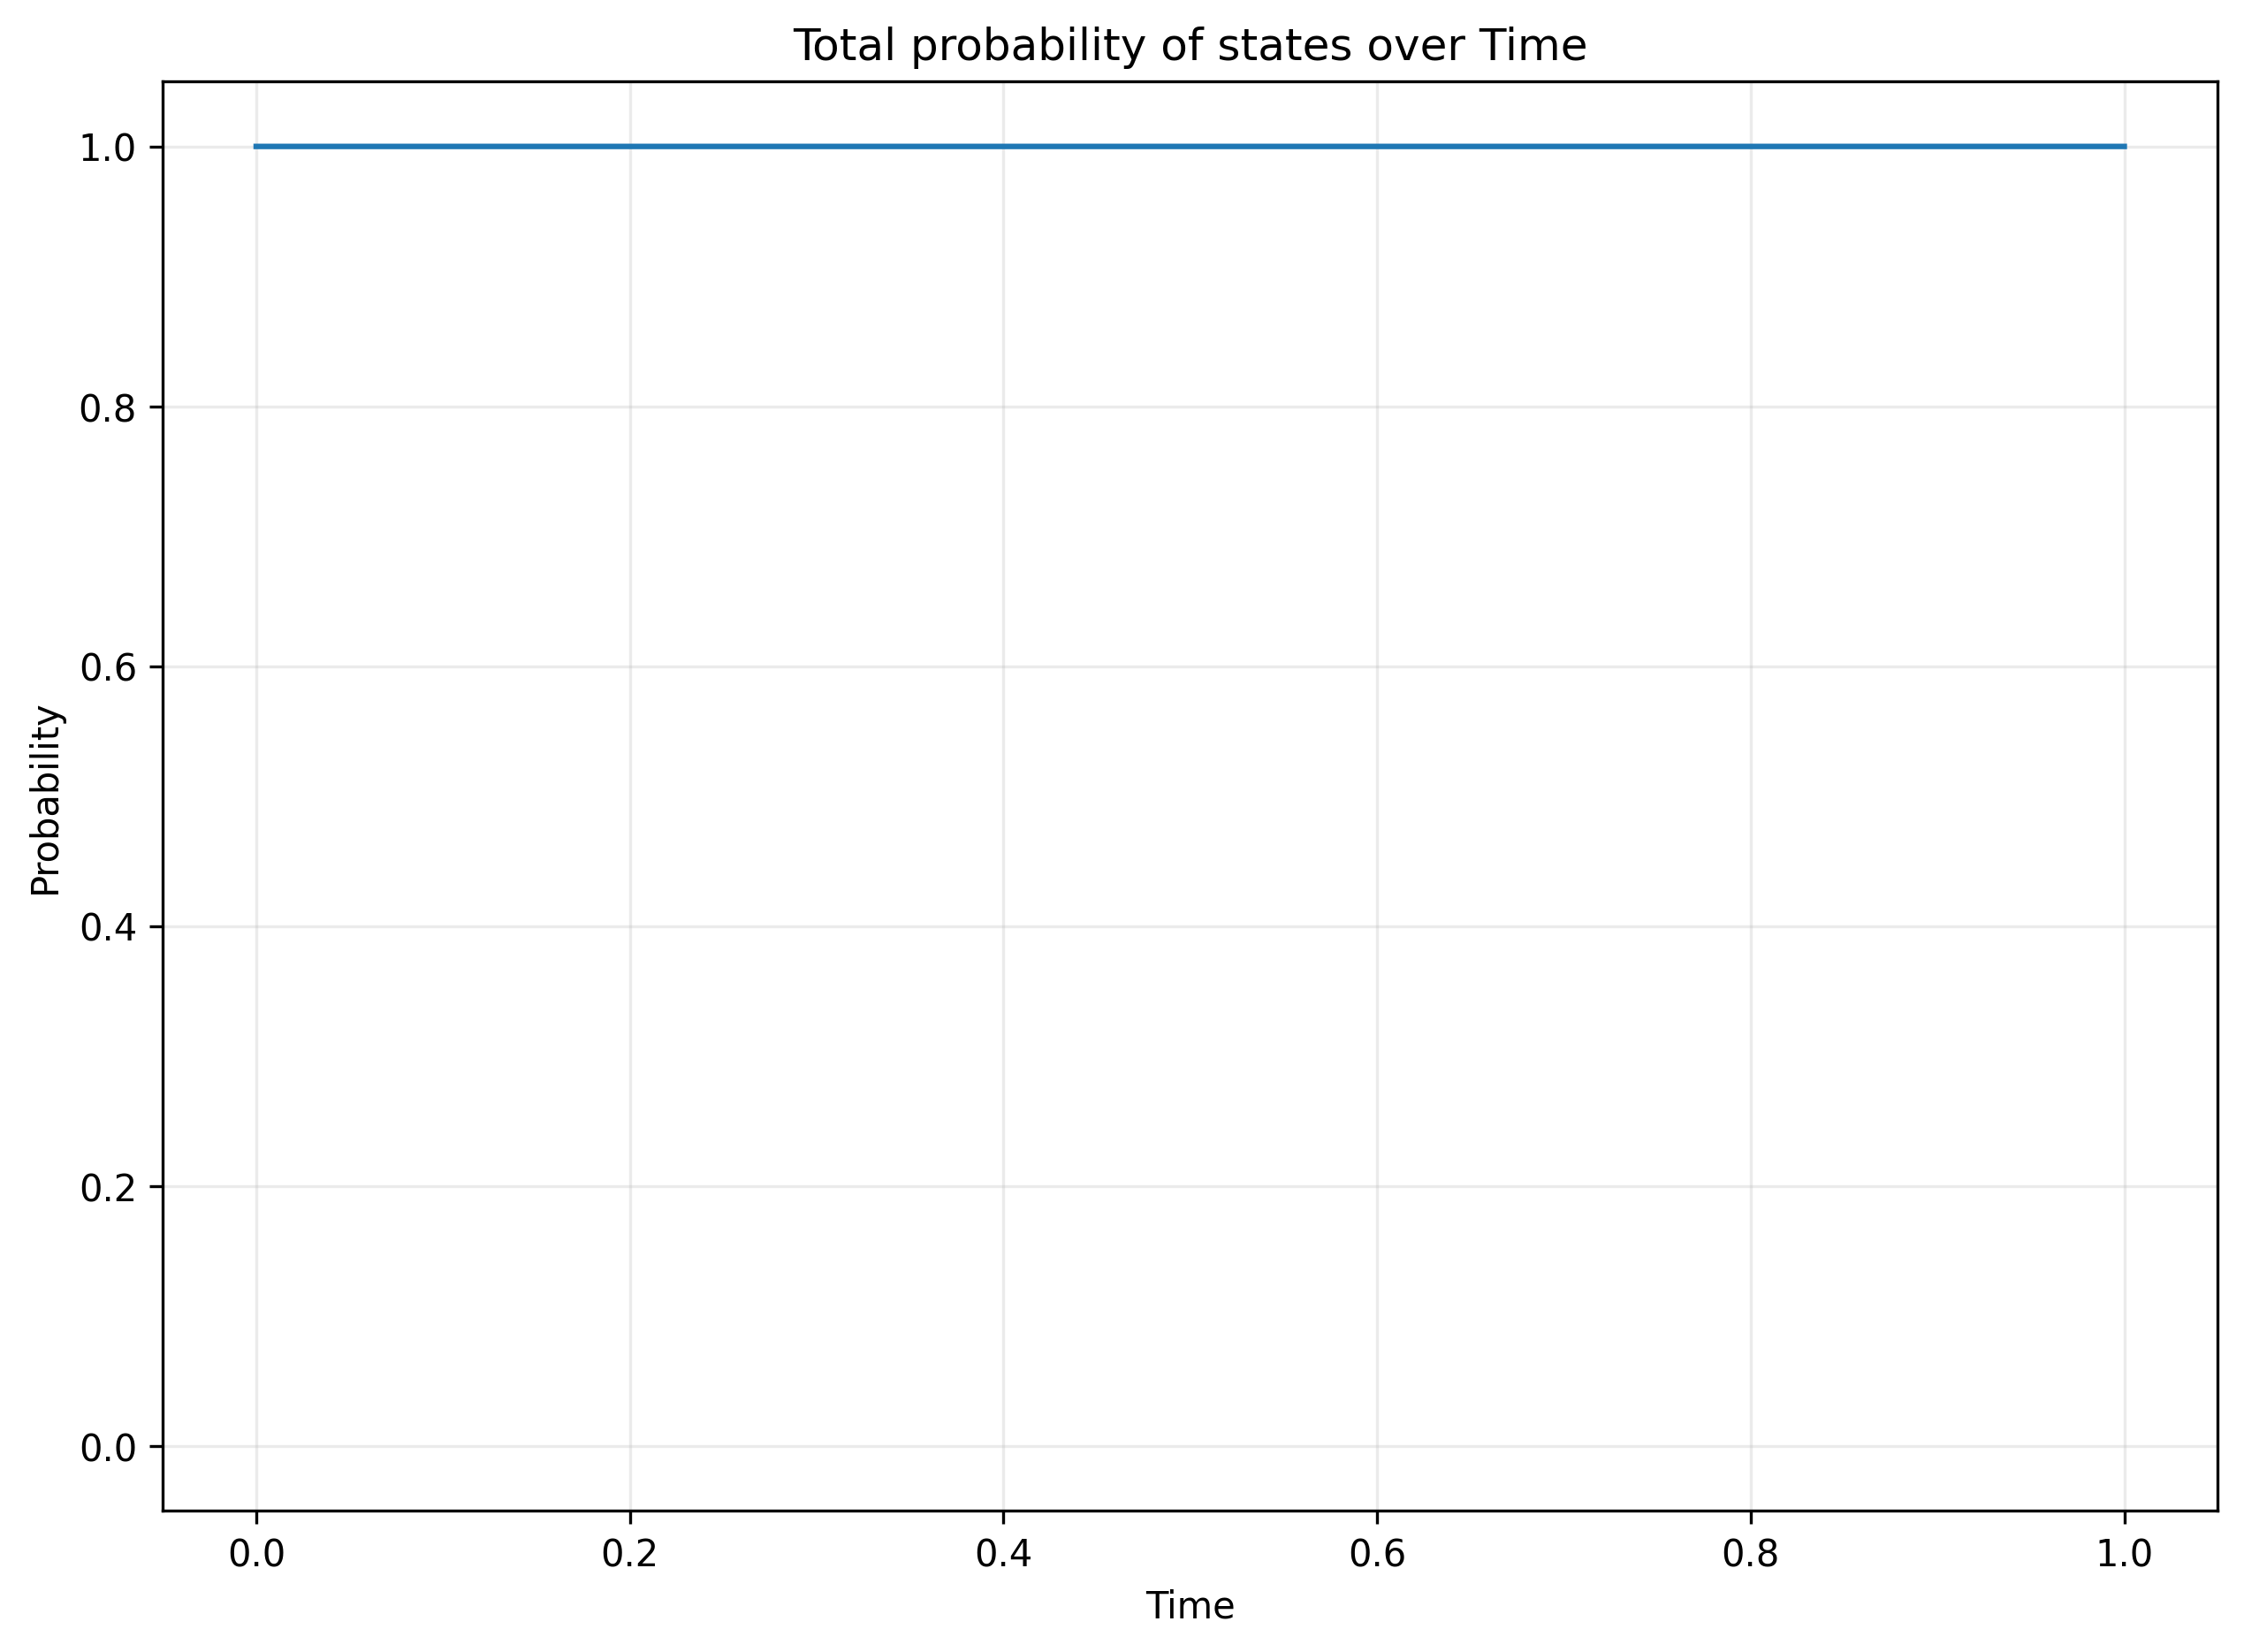

In [18]:
plt.figure(figsize=(10, 7), dpi=300)
plt.plot(
    times,
    [sum(prob) for prob in probabilities],
)

plt.xlabel("Time")
plt.ylabel("Probability")
plt.ylim(-0.05, 1.05)
plt.title("Total probability of states over Time")
plt.grid(True, alpha=0.25)
plt.show()

In [19]:
energies = []

for time in times:
    H_t = H(time)
    e = [expect(H_t, basis_state) for basis_state in basis_states]
    energies.append(e)

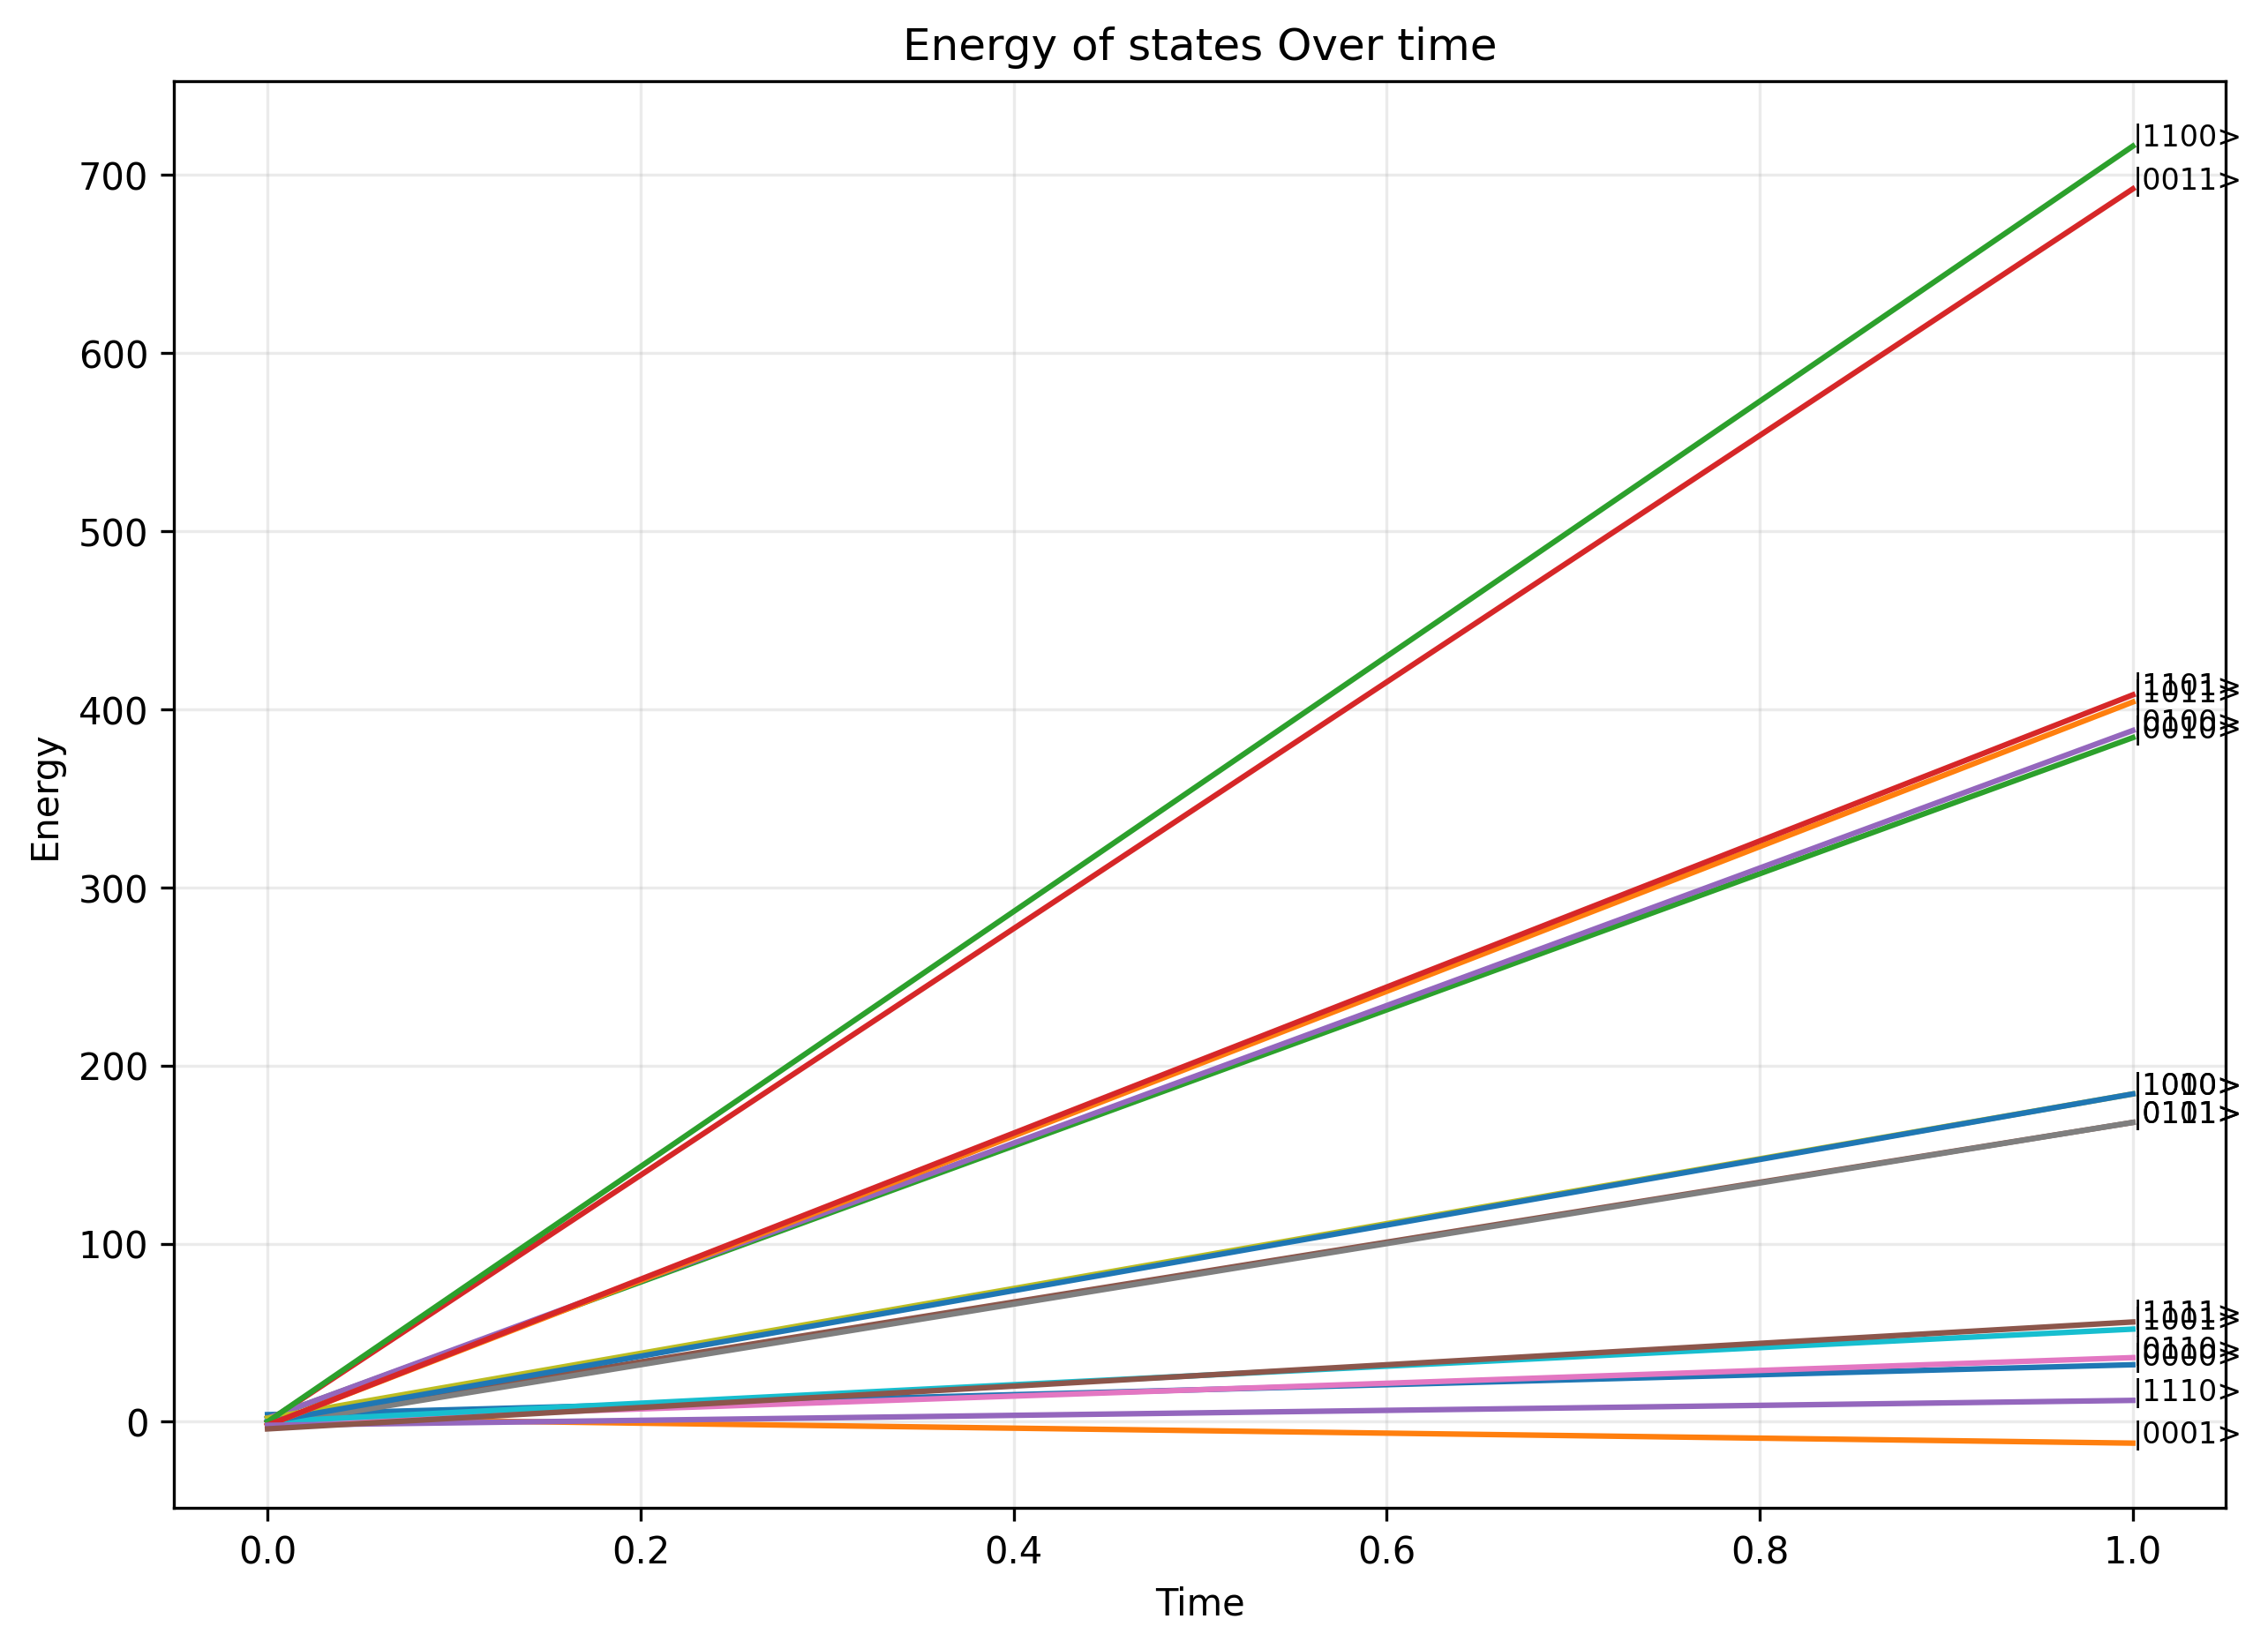

In [20]:
plt.figure(figsize=(10, 7), dpi=300)
for idx in range(num_states):
    plt.plot(
        times,
        [ener[idx] for ener in energies],
        label=f'|{format(idx, "0" + str(total_qubits) + "b")}>',
    )
    plt.text(
        times[-1],
        energies[-1][idx],
        f'|{format(idx, "0" + str(total_qubits) + "b")}>',
        fontsize=8,
    )

plt.xlabel("Time")
plt.ylabel("Energy")
plt.title("Energy of states Over time")
plt.grid(True, alpha=0.25)
plt.show()

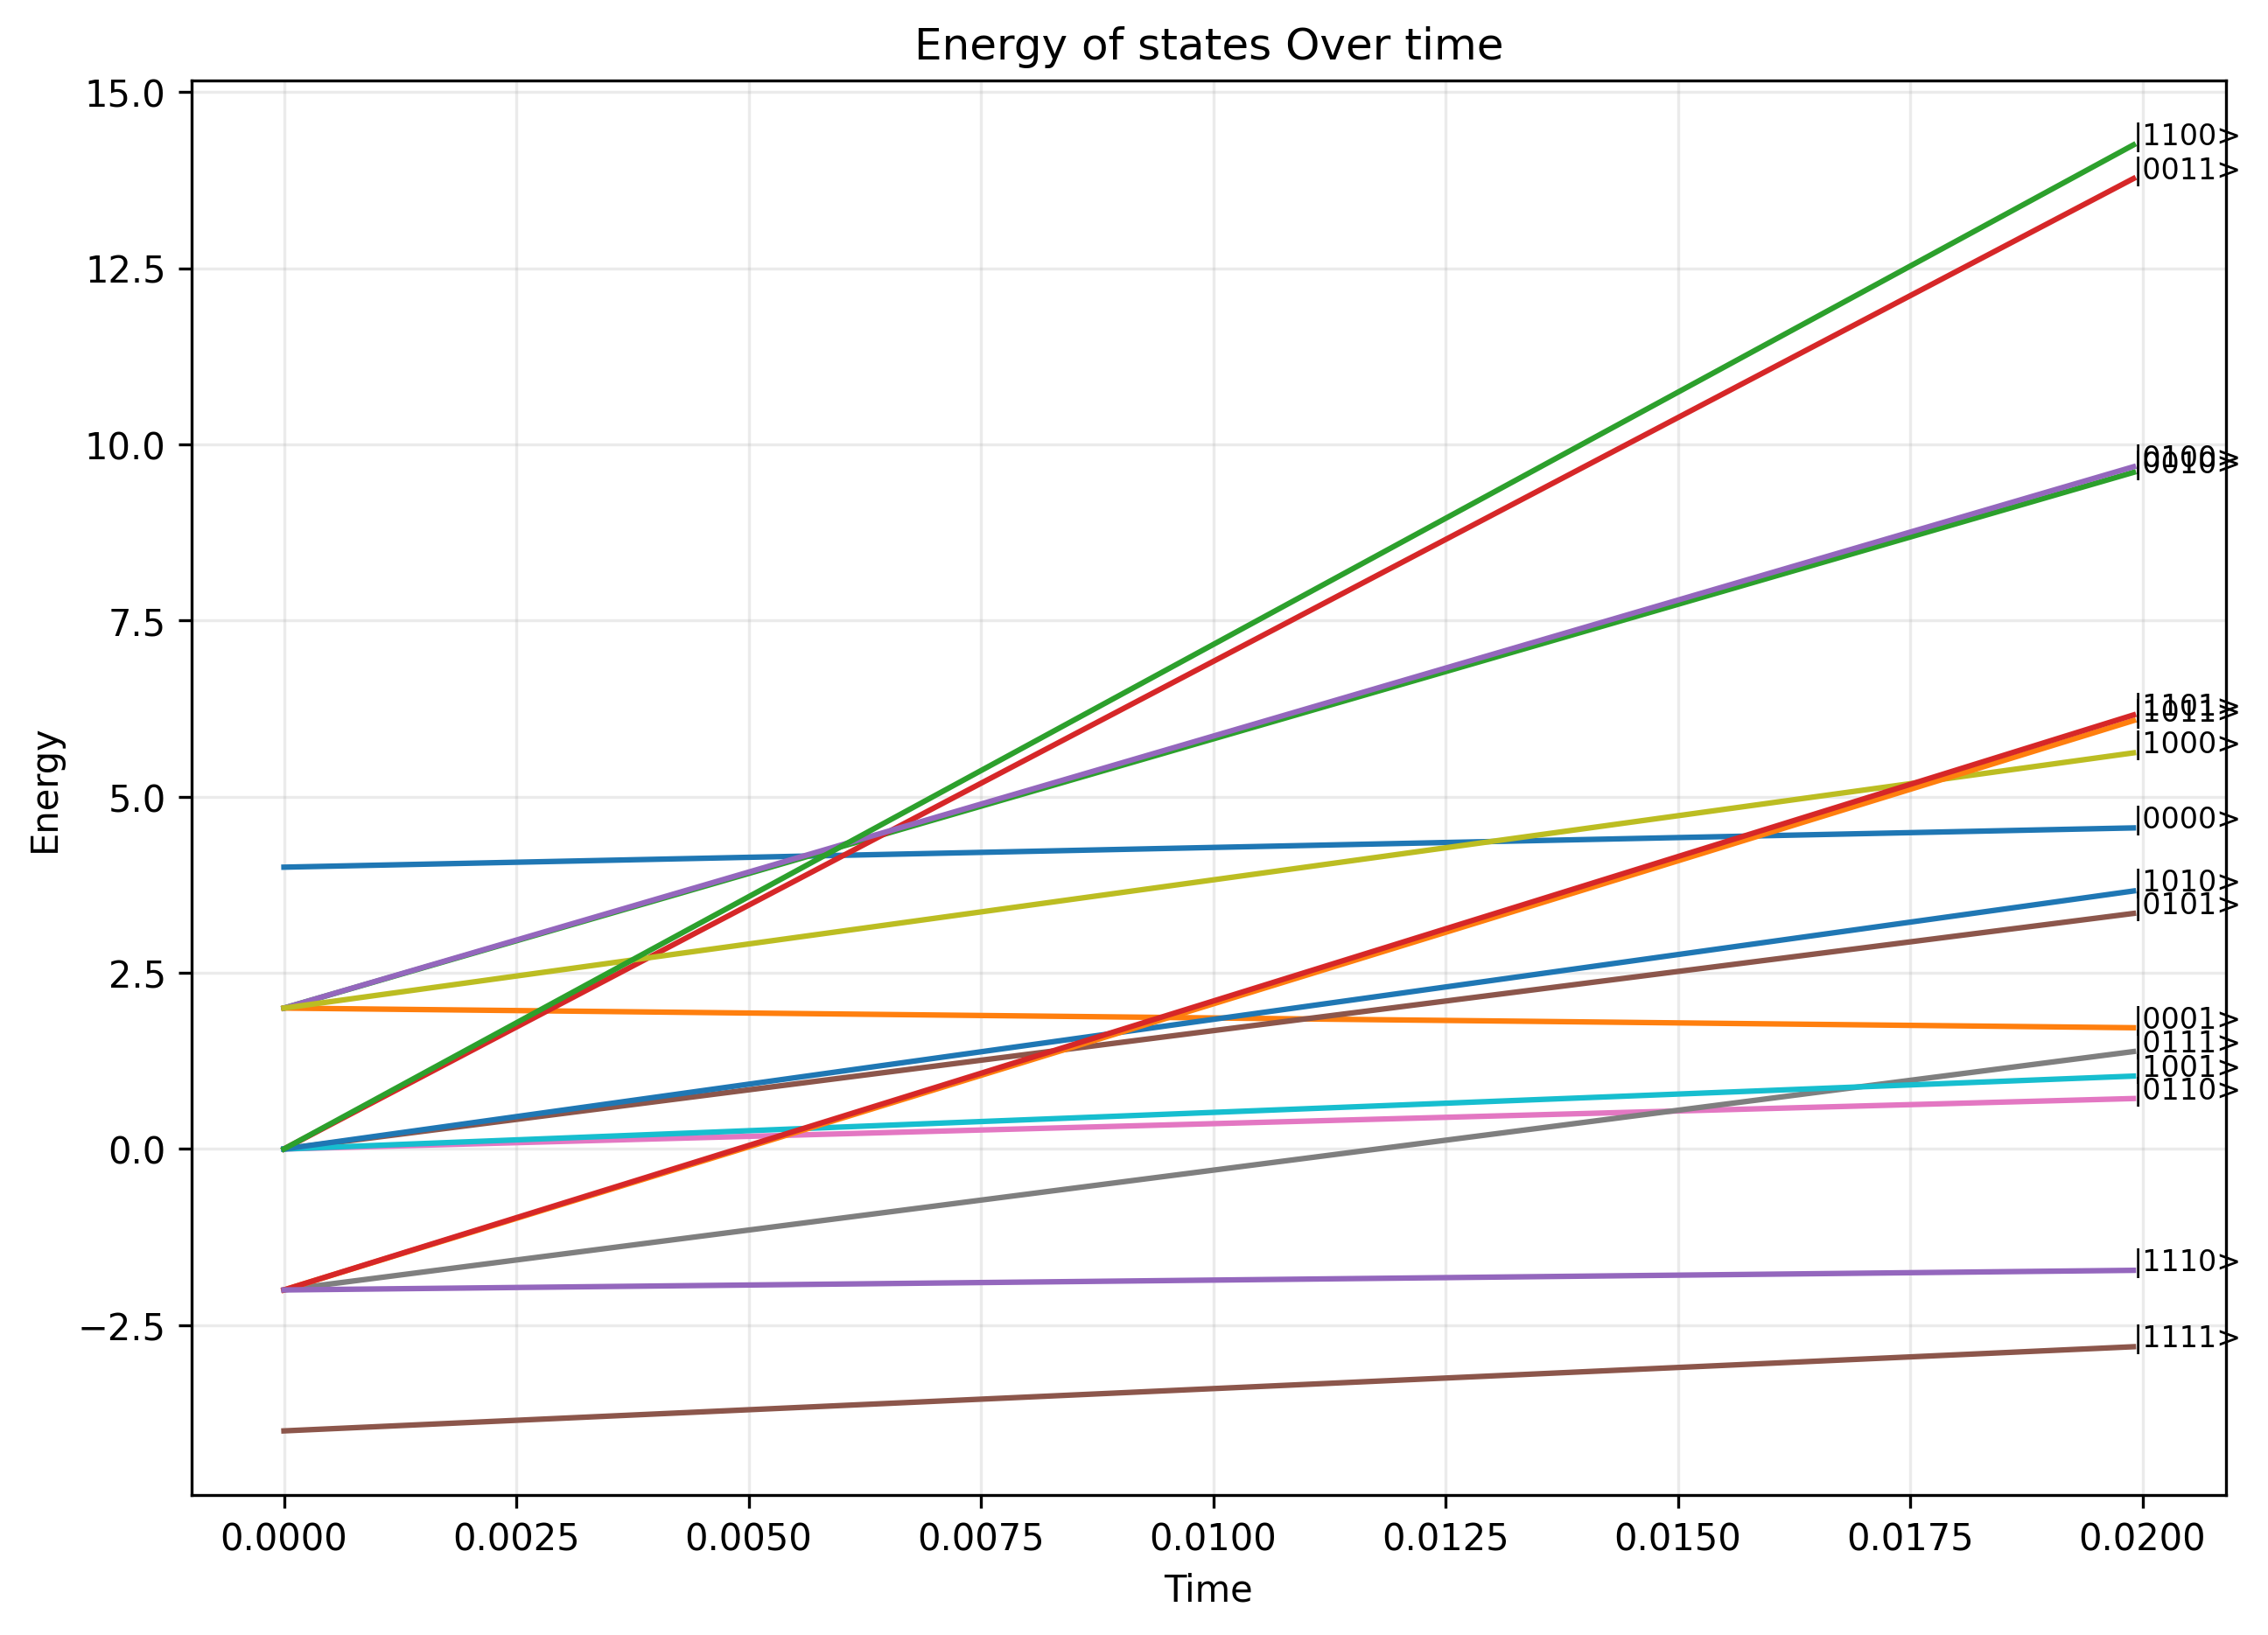

In [21]:
energies = []

for time in times[: len(times) // 50]:
    H_t = H(time)
    e = [expect(H_t, basis_state) for basis_state in basis_states]
    energies.append(e)

plt.figure(figsize=(10, 7), dpi=300)
for idx in range(num_states):
    plt.plot(
        times[: len(times) // 50],
        [ener[idx] for ener in energies],
        label=f'|{format(idx, "0" + str(total_qubits) + "b")}>',
    )
    plt.text(
        times[: len(times) // 50][-1],
        energies[-1][idx],
        f'|{format(idx, "0" + str(total_qubits) + "b")}>',
        fontsize=8,
    )

plt.xlabel("Time")
plt.ylabel("Energy")
plt.title("Energy of states Over time")
plt.grid(True, alpha=0.25)
plt.show()